In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
import json
os.environ["KMP_DUPLICATE_LIB_OK"]='1'

In [14]:
def plot_graphs (history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [3]:
DATA_IN_PATH = '../data-in/'
DATA_OUT_PATH = '../data-out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'nsmc_data_configs.json'

In [4]:
SEED_NUM=1234
tf.random.set_seed(SEED_NUM)

In [5]:
train_input=np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_label=np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA,'rb'))
prepro_configs=json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

0. 인베딩 레이어

1. 

컴펄루션 연산

서브플레이싱


In [6]:
model_name='cnn_classifier_kr'
BATCH_SIZE=512
NUM_POCHS=10
VALID_SPLIT=0.1
MAX_LEN=train_input.shape[1]

kargs={
    'model_name': model_name,
    'vacab_size': prepro_configs['vocab_size'],
    'embedding_size':128,
    'num_filters': 100,
    'dropout_rate': 0.5,
    'hidden_dimension': 250,
    'output_dimension': 1
}

In [7]:
class CNNClassifier(tf.keras.Model):
    def __init__(self,**kargs):
        super(CNNClassifier,self).__init__(name=kargs['model_name'])
        self.embedding=layers.Embedding(kargs['vacab_size']+1, 
                                        kargs['embedding_size'])
        self.conv_list=[
            layers.Conv1D(kargs['num_filters'],kernel_size=kernel_size,
                         padding='valid',activation='relu', 
                         kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                                                                         #최댓값 3설정
            for kernel_size in [3,4,5]            
        ]
        self.pooling =layers.GlobalMaxPooling1D()
        self.dropout =layers.Dropout(kargs['dropout_rate'])
        self.fc1=layers.Dense(kargs['hidden_dimension'],activation='relu', 
                         kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2=layers.Dense(kargs['output_dimension'],activation='sigmoid', 
                         kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        
    def call(self,x):
        x=self.embedding(x)
        x=self.dropout(x)
        x=tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x=self.fc1(x)
        x=self.fc2(x)
        return x

In [8]:
model =CNNClassifier(**kargs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
early_stop = EarlyStopping(monitor='val_accuracy',min_delta=0.0001,
                          patience=3)

chackpoint_path=DATA_OUT_PATH+model_name+'/weights.h5'
chackpoint_dir = os.path.dirname(chackpoint_path)

if not os.path.exists(chackpoint_dir):
    os.mkdir(chackpoint_dir)
    
model_checkpoint=ModelCheckpoint(chackpoint_path, monitor='val_accuracy',
                                verbose=1, save_best_only=True,
                                save_weights_only=True)

In [10]:
history=model.fit(train_input,train_label, batch_size=BATCH_SIZE,
                 epochs=NUM_POCHS, validation_split=VALID_SPLIT,
                 callbacks=[early_stop, model_checkpoint])

Epoch 1/10
264/264 [==============================] - ETA: 0s - loss: 0.4586 - accuracy: 0.7756
Epoch 1: val_accuracy improved from -inf to 0.81967, saving model to ../data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 18s 61ms/step - loss: 0.4586 - accuracy: 0.7756 - val_loss: 0.3963 - val_accuracy: 0.8197
Epoch 2/10
264/264 [==============================] - ETA: 0s - loss: 0.3520 - accuracy: 0.8456
Epoch 2: val_accuracy improved from 0.81967 to 0.82880, saving model to ../data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 16s 59ms/step - loss: 0.3520 - accuracy: 0.8456 - val_loss: 0.3853 - val_accuracy: 0.8288
Epoch 3/10
264/264 [==============================] - ETA: 0s - loss: 0.3000 - accuracy: 0.8723
Epoch 3: val_accuracy did not improve from 0.82880
264/264 [==============================] - 16s 59ms/step - loss: 0.3000 - accuracy: 0.8723 - val_loss: 0.3960 - val_accuracy: 0.8223
Epoch 4/10
264/264 [===================

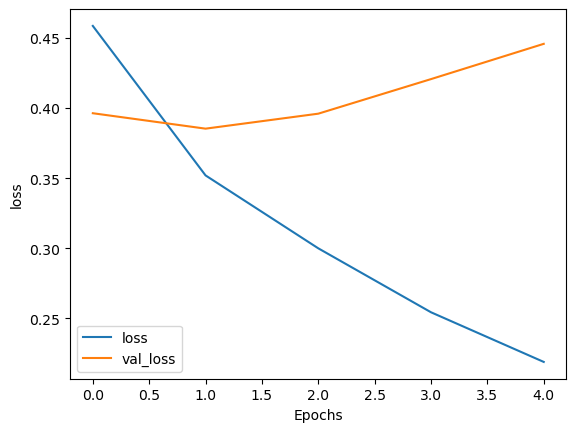

In [15]:
import matplotlib.pyplot as plt
plot_graphs(history, 'loss')

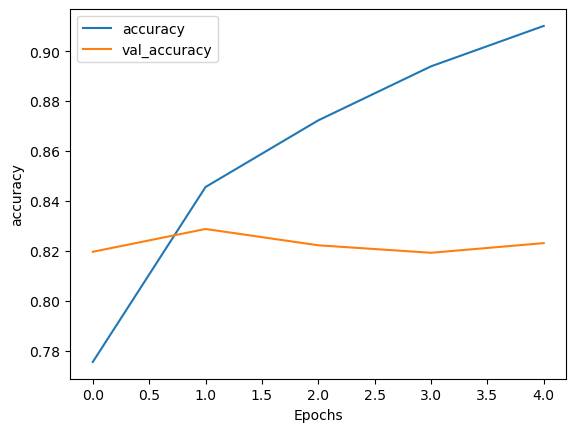

In [16]:
plot_graphs(history, 'accuracy')

In [17]:
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'

test_input = np.load(open(DATA_IN_PATH+INPUT_TEST_DATA, 'rb'))
test_label_data =np.load(open(DATA_IN_PATH+LABEL_TEST_DATA, 'rb'))

In [18]:
model.load_weights(os.path.join(DATA_OUT_PATH,model_name,'weights.h5'))

In [19]:
model.evaluate(test_input,test_label_data)

1563/1563 [==============================] - 3s 2ms/step - loss: 0.3872 - accuracy: 0.8268


[0.3872051239013672, 0.8268200159072876]